## **Projet de machine Learning : utilisation de différents méthodes de machine Learning pour la détection d'anomalies de la pomme de terre**



---





**Importation des libraries**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import warnings
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split, StratifiedKFold
from  sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score , confusion_matrix, classification_report
from sklearn import svm
from imblearn.over_sampling import SMOTE
warnings.filterwarnings("ignore")
from sklearn.metrics import ConfusionMatrixDisplay


**Connecter kaggle pour importer notre base de données**

In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle/

In [ ]:
! cp '/content/drive/MyDrive/kaggle.json' ~/.kaggle/

cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download -d aarishasifkhan/plantvillage-potato-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/aarishasifkhan/plantvillage-potato-disease-dataset
License(s): apache-2.0
 95% 36.0M/37.8M [00:00<00:00, 79.3MB/s]
100% 37.8M/37.8M [00:00<00:00, 79.7MB/s]


In [ ]:
! unzip /content/plantvillage-potato-disease-dataset.zip -d dataset_ML

Archive:  /content/plantvillage-potato-disease-dataset.zip
  inflating: dataset_ML/PlantVillage/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG  
  inflating: dataset_ML/PlantVillage/Potato___Early_blight/002a55fb-7a3d-4a3a-aca8-ce2d5ebc6925___RS_Early.B 8170.JPG  
  inflating: dataset_ML/PlantVillage/Potato___Early_blight/009c8c31-f22d-4ffd-8f16-189c6f06c577___RS_Early.B 7885.JPG  
  inflating: dataset_ML/PlantVillage/Potato___Early_blight/00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG  
  inflating: dataset_ML/PlantVillage/Potato___Early_blight/0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015.JPG  
  inflating: dataset_ML/PlantVillage/Potato___Early_blight/02578b86-b234-4ac0-9bc3-691b5610e2bf___RS_Early.B 7562.JPG  
  inflating: dataset_ML/PlantVillage/Potato___Early_blight/0267d4ca-522e-4ca0-b1a2-ce925e5b54a2___RS_Early.B 7020.JPG  
  inflating: dataset_ML/PlantVillage/Potato___Early_blight/028f9b73-142f-499a-9c7b-d7c1ed5e5506___RS_

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Exploration de nombre d'image disponible**

In [ ]:
import pandas as pd

file_path = '/content/dataset_ML/PlantVillage'
class_dirs = ['Potato___Late_blight', 'Potato___Early_blight', 'Potato___healthy']
for class_dir in class_dirs:
    class_path = os.path.join(file_path, class_dir)
    num_images = len(os.listdir(class_path))
    print(f"Class: {class_dir}, Number of Images: {num_images}")

Class: Potato___Late_blight, Number of Images: 1000
Class: Potato___Early_blight, Number of Images: 1000
Class: Potato___healthy, Number of Images: 152


In [ ]:
total_images = sum(len(os.listdir(os.path.join(file_path, class_dir))) for class_dir in class_dirs)
print(f"Total Number of Images in Dataset: {total_images}")

Total Number of Images in Dataset: 2152


**Prétraitement des images :**

*   redimensionnement des images en (150*150) avec 3 canaux de couleur
*   Donnés applaties en un tableau 1D









In [ ]:
file_path = '/content/dataset_ML/PlantVillage'
class_dirs = ['Potato___Late_blight', 'Potato___Early_blight', 'Potato___healthy']
target = []
flat_data_arr = []
for label, i in enumerate(class_dirs):
  print("loading category : {", i, "}")
  path = os.path.join(file_path,i)
  for j in os.listdir(path):
    img_array = imread(os.path.join(path,j))
    img_resize = resize(img_array,(150,150,3))
    #flat_data_arr = img_resize.flatten()
    flat_data_arr.append(img_resize.flatten())
    target.append(label)
  print(f"loaded category:{i} successfully")
flat_data = np.array(flat_data_arr)
target = np.array(target)

loading category : { Potato___Late_blight }
loaded category:Potato___Late_blight successfully
loading category : { Potato___Early_blight }
loaded category:Potato___Early_blight successfully
loading category : { Potato___healthy }
loaded category:Potato___healthy successfully


In [ ]:
print(target.shape)
print(flat_data.shape)


(2152,)
(2152, 67500)


**Données converties en DataFrame puis divisé en x et y**

In [ ]:
df2 = pd.DataFrame(flat_data)
df2['Target'] = target
df2

,0,1,2,3,4,5,6,7,8,9,...,67491,67492,67493,67494,67495,67496,67497,67498,67499,Target
0,0.384877,0.349583,0.424093,0.406290,0.370996,0.445506,0.424406,0.389112,0.463622,0.420539,...,0.618709,0.583415,0.650082,0.616249,0.580955,0.647622,0.612371,0.577077,0.643743,0
1,0.559480,0.539872,0.618304,0.564273,0.544665,0.623096,0.566751,0.547143,0.625574,0.565657,...,0.483833,0.456382,0.519127,0.443994,0.416543,0.479288,0.404663,0.377212,0.439957,0
2,0.307092,0.279641,0.311014,0.318998,0.291547,0.322920,0.313348,0.285897,0.317269,0.307766,...,0.591179,0.571572,0.599022,0.597193,0.577585,0.605036,0.587279,0.567671,0.595122,0
3,0.416476,0.385103,0.436083,0.432635,0.401262,0.452242,0.450121,0.418749,0.469729,0.447982,...,0.685609,0.673844,0.716981,0.679179,0.667414,0.710551,0.656199,0.644435,0.687572,0
4,0.668603,0.645074,0.660760,0.616734,0.593204,0.608890,0.676836,0.653307,0.668993,0.702238,...,0.497849,0.443862,0.428778,0.469776,0.422482,0.364391,0.460335,0.417165,0.341750,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147,0.694530,0.671000,0.671000,0.689140,0.665611,0.665611,0.689693,0.666164,0.666164,0.698181,...,0.621306,0.578168,0.593855,0.594535,0.551398,0.567084,0.593552,0.550415,0.566101,2
2148,0.591837,0.509485,0.529092,0.534390,0.452037,0.471645,0.506859,0.424506,0.444114,0.568976,...,0.626522,0.559855,0.599071,0.656789,0.590122,0.629338,0.675667,0.609000,0.648216,2
2149,0.592285,0.517775,0.541304,0.615835,0.541325,0.564855,0.627855,0.553345,0.576874,0.613455,...,0.719528,0.660705,0.688156,0.633068,0.574245,0.601696,0.754780,0.695957,0.723408,2
2150,0.568808,0.502141,0.533514,0.628927,0.562261,0.593633,0.608792,0.542125,0.573498,0.576831,...,0.561298,0.494632,0.526004,0.552076,0.485409,0.516782,0.577456,0.510789,0.542161,2


In [ ]:
x=df2.iloc[:,:-1]
y=df2.iloc[:,-1]

In [ ]:
y

,Target
0,0
1,0
2,0
3,0
4,0
...,...
2147,2
2148,2
2149,2
2150,2


**Division des données en donées d'entrainnement et de test**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1721, 67500)
(431, 67500)
(1721,)
(431,)


In [ ]:
##SAMPLING STRATEGY = minority equivalent c'est a dire qu'on reechantillone la classe mioritaire
smote = SMOTE(sampling_strategy='minority', random_state=42, k_neighbors=5)
X_train2, y_train2 = smote.fit_resample(X_train, y_train)


In [ ]:
print(X_train2.shape)
print(y_train2.shape)


(2410, 67500)
(2410,)


In [ ]:
y_train.value_counts()

,count
Target,
0,804
1,802
2,115


In [ ]:
y_train2.info()
y_train2.value_counts()

<class 'pandas.core.series.Series'>
RangeIndex: 2410 entries, 0 to 2409
Series name: Target
Non-Null Count  Dtype
--------------  -----
2410 non-null   int64
dtypes: int64(1)
memory usage: 19.0 KB


,count
Target,
0,804
2,804
1,802


### **SVM model**

Choix des hyperparametres du model :
- kernel : lineair , on choisit de travailler avec une separation lineaire vu que le travaille avec une transformation par noyau n'apportera beaucoup d'information dans ce cas
- decision_function_shape="ovr" : classificateur un contre le reste au lieu d'un contre un .

In [ ]:
svm1 = svm.SVC(kernel='linear',decision_function_shape="ovr")
svm1.fit(X_train2, y_train2)

SVC(kernel='linear')

In [ ]:
y_pred = svm1.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))


Accuracy: 91.42%
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       196
           1       0.95      0.94      0.95       198
           2       0.95      0.57      0.71        37

    accuracy                           0.91       431
   macro avg       0.93      0.82      0.86       431
weighted avg       0.92      0.91      0.91       431



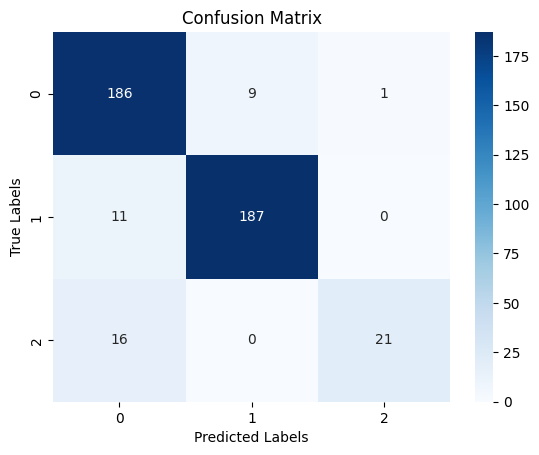

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
svm1.support_vectors_
##  nombre de vecteurs de support pour chaque classe.
svm1.n_support_

array([357, 285, 257], dtype=int32)

LinearSVC : strategie multiclasse : une contre les autres

In [ ]:
svm2 = svm.LinearSVC()
svm2.fit(X_train, y_train)

LinearSVC()

In [ ]:
y_pred = svm2.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))

Accuracy: 86.31%
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       196
           1       0.94      0.91      0.92       198
           2       0.83      0.27      0.41        37

    accuracy                           0.86       431
   macro avg       0.86      0.70      0.73       431
weighted avg       0.87      0.86      0.85       431



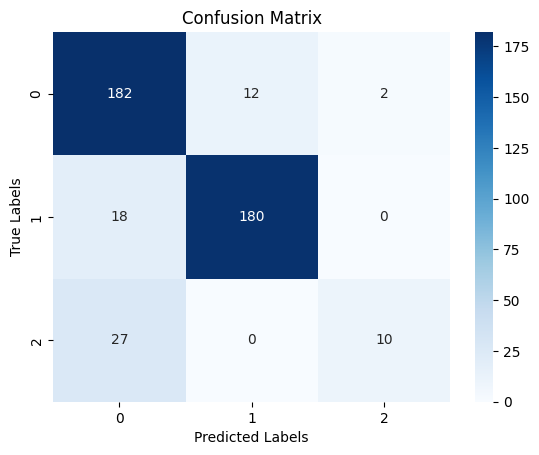

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

- Accuracy (Précision globale) :
SVC(kernel='linear') atteint une précision plus élevée (91.42%) par rapport à LinearSVC() (86.31%).
-Classe 2 (faible support) : Les deux modèles rencontrent des difficultés avec la classe 2 (qui n'a que 37 exemples). Cependant, SVC(kernel='linear') gère mieux cette classe (F1-score de 0.71 avec un rappel de 0.57) que LinearSVC() (F1-score de 0.41 avec un rappel de 0.27).
- Macro avg : SVC(kernel='linear') a des scores moyens plus élevés en précision, rappel, et F1-score par rapport à LinearSVC(). Cela indique une meilleure performance générale dans le traitement des classes, même si les classes sont déséquilibrées en termes de support.
-Weighted avg : Les moyennes pondérées montrent que SVC(kernel='linear') obtient de meilleures performances globales, avec des scores plus élevés pour la précision, le rappel et le F1-score pondérés.
Donc pour la suite on choisit de travailler avec le SVC

Definir les hyperparametres de notre modele SVM

- kernel : fixe au lineaire
- c :1 par defaut, parametre de regularisation (plus il est eleve plus la penalite de malclasser est large , separation trop finee et pourrait etre tres influencee par quelques points ), controle le compromis entre maximiser la marge et minimiser l'erreur de classification ,   
- gamma : determine l'influence de chaque vecteur de support dans l'espace d'entree , si faible leur influence devient large et par suite les frontieres de decision deviennent lisses

**GridSearchCV**

In [ ]:
param_grid = {'C': [0.1,10], 'gamma': [1, 0.1]}
#SVM = svm.SVC(probability=True)
kfold = StratifiedKFold(n_splits=3,shuffle=True)
model = GridSearchCV(svm1, param_grid,cv=kfold)
model.fit(X_train2, y_train2)

NameError: name 'StratifiedKFold' is not defined

## **Arbre de decision**

In [ ]:
from sklearn.tree import DecisionTreeClassifier


Hyperparametres
- critere : fonction de mesure de la qualite d'une division (gini,log_loss,entropy) ,  par defaut gini généralement plus rapide que entropy et souvent donne des résultats similaires.
- max_depth : profondeur maximale de l'arbre
Une valeur de 10 est un bon compromis pour éviter que l'arbre ne devienne trop profond et surapprenne (overfitting), tout en conservant une certaine capacité de généralisation
- min_samples_split : nbr min d'echnantillon pour diviser un noeud interne
Une valeur de 2 est la valeur par défaut et permet de maximiser la capacité de l'arbre à se diviser autant que nécessaire

- min_samples_leaf : nbr min d'echantillon requis pour un noeud feuille
1 est la valeur par défaut, ce qui permet à l'arbre d'aller jusqu'à diviser jusqu'à ce qu'il y ait un seul échantillon dans une feuille.

In [ ]:
#param_grid_dt = {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10], 'criterion': ['gini', 'entropy']}
dt_model = DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=1, criterion='gini', random_state=42)
#dt_model = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5)
dt_model.fit(X_train2, y_train2)

# Prédictions et évaluation
dt_pred = dt_model.predict(X_test)
dt_accuracy = accuracy_score(dt_pred, y_test)
print(f"Decision Tree Accuracy: {dt_accuracy:.2f}")
print(classification_report(y_test, dt_pred))

Decision Tree Accuracy: 0.73
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       196
           1       0.79      0.77      0.78       198
           2       0.47      0.46      0.47        37

    accuracy                           0.73       431
   macro avg       0.66      0.66      0.66       431
weighted avg       0.73      0.73      0.73       431



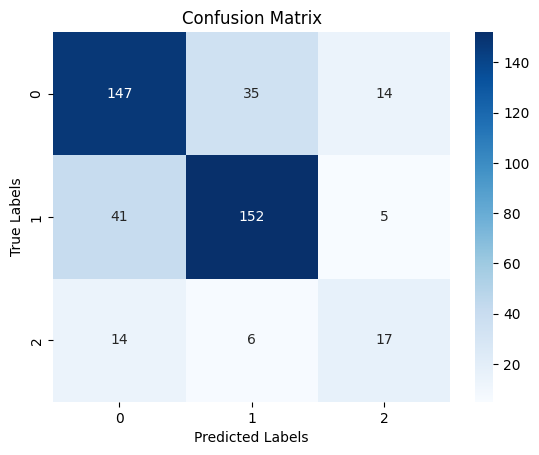

In [ ]:
sns.heatmap(confusion_matrix(y_test, dt_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

- min_samples_split = 2 peut parfois conduire à un surapprentissage , tester avec  5
- min_samples_leaf=1  fonctionne bien si données ne sont pas trop bruitées, on teste avec 2 ou 5

In [ ]:
dt_model = DecisionTreeClassifier(max_depth=10, min_samples_split=5, min_samples_leaf=1, criterion='gini', random_state=42)
dt_model.fit(X_train2, y_train2)

# Prédictions et évaluation
dt_pred = dt_model.predict(X_test)
dt_accuracy = accuracy_score(dt_pred, y_test)
print(f"Decision Tree Accuracy: {dt_accuracy:.2f}")
print(classification_report(y_test, dt_pred))

Decision Tree Accuracy: 0.74
              precision    recall  f1-score   support

           0       0.73      0.78      0.75       196
           1       0.80      0.75      0.77       198
           2       0.46      0.46      0.46        37

    accuracy                           0.74       431
   macro avg       0.66      0.66      0.66       431
weighted avg       0.74      0.74      0.74       431



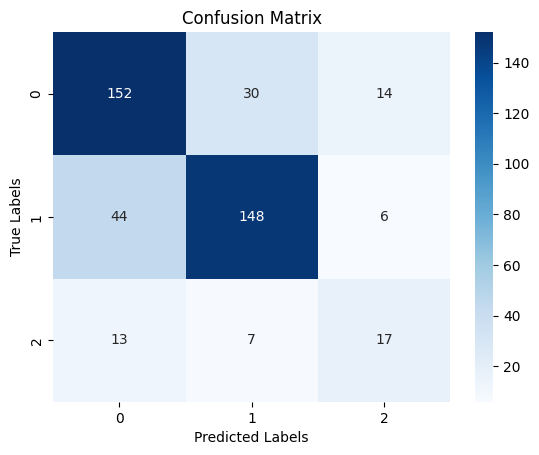

In [ ]:
sns.heatmap(confusion_matrix(y_test, dt_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

On remarque que le modele ne s'est pas ameliore d'ou on garde min_samples_split=2

In [ ]:
dt_model = DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=2, criterion='gini', random_state=42)
dt_model.fit(X_train2, y_train2)

# Prédictions et évaluation
dt_pred = dt_model.predict(X_test)
dt_accuracy = accuracy_score(dt_pred, y_test)
print(f"Decision Tree Accuracy: {dt_accuracy:.2f}")
print(classification_report(y_test, dt_pred))

Decision Tree Accuracy: 0.73
              precision    recall  f1-score   support

           0       0.72      0.77      0.74       196
           1       0.80      0.75      0.77       198
           2       0.49      0.46      0.47        37

    accuracy                           0.73       431
   macro avg       0.67      0.66      0.66       431
weighted avg       0.73      0.73      0.73       431



In [ ]:
sns.heatmap(confusion_matrix(y_test, dt_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
dt_model = DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=5, criterion='gini', random_state=42)
dt_model.fit(X_train2, y_train2)

# Prédictions et évaluation
dt_pred = dt_model.predict(X_test)
dt_accuracy = accuracy_score(dt_pred, y_test)
print(f"Decision Tree Accuracy: {dt_accuracy:.2f}")
print(classification_report(y_test, dt_pred))

**GridSearchCV**

In [ ]:
param_grid_dt = {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5]}
#dt_model = DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=1, criterion='gini', random_state=42)
dt_model = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5)
dt_model.fit(X_train2, y_train2)

# Prédictions et évaluation
dt_pred = dt_model.predict(X_test)
dt_accuracy = accuracy_score(dt_pred, y_test)
print(f"Decision Tree Accuracy: {dt_accuracy:.2f}")
print(classification_report(y_test, dt_pred))

### **Random Forest**###

- max_features : nbr de features a considerer dans chaque split ,sqrt , Cela signifie que pour chaque arbre, un sous-ensemble aléatoire de caractéristiques de taille égale à la racine carrée du nombre total de caractéristiques sera considéré.
- n_estimators : nbr d'arbre .Un nombre de 100 est souvent un bon point de départ pour un Random Forest, car il permet de construire suffisamment d'arbres pour capturer des modèles complexes tout en maintenant un temps d'entraînement raisonnable.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100,min_samples_split=2, min_samples_leaf=1, max_features='sqrt', random_state=42)
rf_model.fit(X_train2, y_train2)
# Evaluate the model
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Random Forest Accuracy: 0.90
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       196
           1       0.90      0.96      0.93       198
           2       0.92      0.62      0.74        37

    accuracy                           0.90       431
   macro avg       0.91      0.82      0.86       431
weighted avg       0.90      0.90      0.90       431



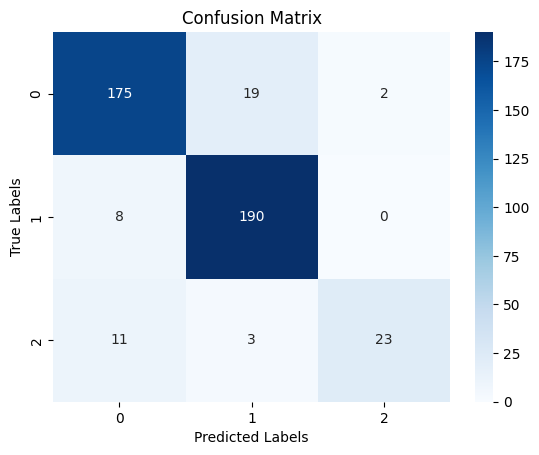

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Courbe ROC

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_pred_bin = label_binarize(y_pred, classes=[0, 1, 2])


In [ ]:
y_test_bin

,0,1,2
0,0,1,0
1,0,1,0
2,1,0,0
3,1,0,0
4,0,1,0
...,...,...,...
426,1,0,0
427,0,1,0
428,1,0,0
429,1,0,0


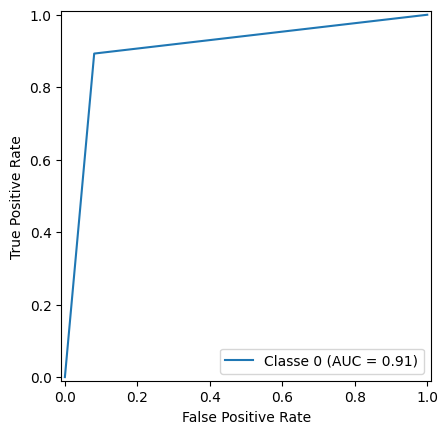

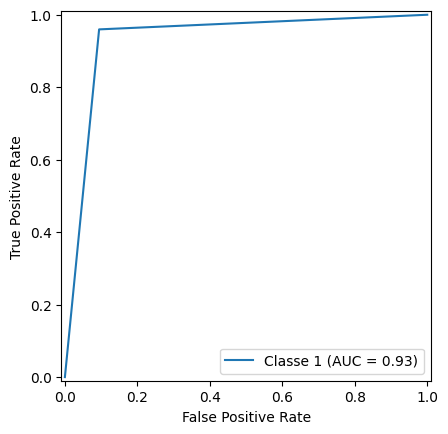

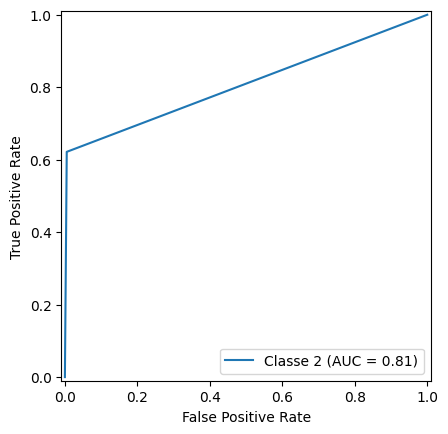

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

#  binariser les labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_pred_bin = label_binarize(y_pred, classes=[0, 1, 2])

# Tracer une courbe ROC pour chaque classe
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=f'Classe {i}')
    display.plot()

plt.show()


- CLASS 0
La courbe monte rapidement au début, ce qui signifie que le modèle est très efficace pour classer les exemples de la Classe 0 avec peu de faux positifs.
Le plateau indique que même à des niveaux plus élevés de FPR, le modèle continue à bien prédire les vrais positifs pour la Classe 0, renforçant l'idée que le modèle est robuste.

- CLASS 2
plus le nombbre de FPR augmente plus le nbr de TPR augmente aussi mais pas assez comme pour les 2 autres classes avec un AUC=0.8

Importance des caractéristiques

Learning Curve (Courbe d'apprentissage):
Chaque courbe montre la précision (la proportion de prédictions correctes parmi les instances prédites positives) par rapport au rappel (la proportion de vraies instances positives correctement identifiées) pour une classe donnée.

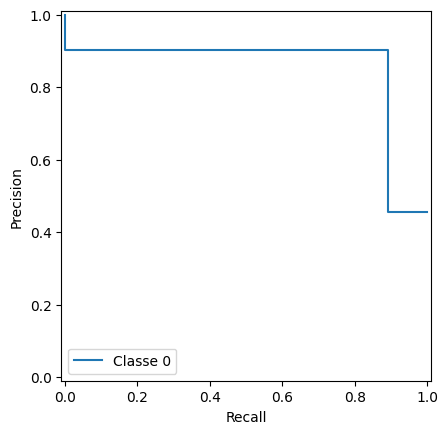

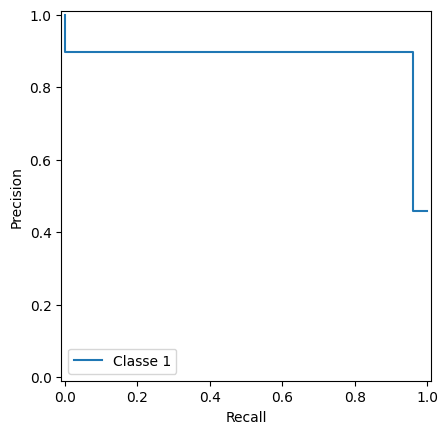

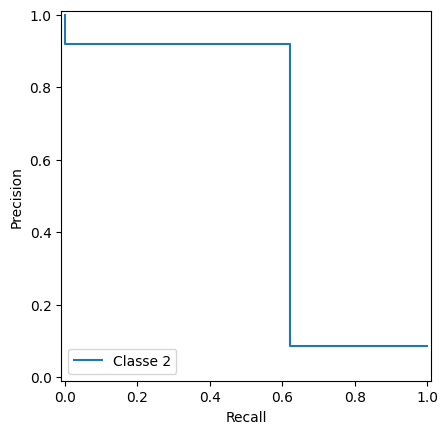

In [ ]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

for i in range(y_test_bin.shape[1]):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_bin[:, i])
    display = PrecisionRecallDisplay(precision=precision, recall=recall, estimator_name=f'Classe {i}')
    display.plot()


plt.show()


- POUR LA 1 ERE CLASSE
La précision est élevée presque tout au long de la courbe. Cela signifie que lorsque le modèle fait des prédictions pour la Classe 0, il est généralement très précis.
Le rappel commence également proche de 1, ce qui signifie que le modèle détecte bien la plupart des exemples positifs de cette classe.
Cependant, la courbe chute abruptement, indiquant qu'au-delà d'un certain point, la précision diminue fortement à mesure que le modèle devient moins confiant dans ses prédictions.

- POUR LA 3 EME
La courbe pour la Classe 2 montre un rappel plus faible, indiquant que le modèle n'identifie pas bien toutes les instances de cette classe. Cela est typique lorsque le modèle rencontre des difficultés avec des classes minoritaires (ici, la Classe 2).
La chute rapide dans la précision montre que le modèle fait de nombreuses fausses prédictions lorsqu'il essaie de prédire la Classe 2.



### **CONCLUSION**
**Ainsi, nous constatons que les deux modèles, Random Forest (RF) et Support Vector Machine (SVM), sont les plus optimaux pour notre base de données. Cependant, les résultats pour la troisième classe demeurent moins satisfaisants en raison de son déséquilibre, même après l'application de la méthode SMOTE.**